### Sentiment Analysis using RNNs
We have a dataset of combined reviews for films from IMDB and Rotten Tomatoes.

- **Task**: build a model that can predict a sentiment (positive/negative) based on a user's review.

In [124]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import (
    Input, Lambda, Dropout,
    Activation, Dense, Embedding,
    SimpleRNN, Conv1D, GlobalMaxPooling1D,
    MaxPooling1D, LSTM
)
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential, Model


from tqdm import tqdm

### Data Downloading

In [2]:
RANDOM_SEED = 23
VALIDATION_SIZE = 0.1

# parameters for vocab and embeddings
VOCAB_SIZE = 10_000
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 50

In [3]:
train_df = pd.read_csv('/home/jovyan/work/data_sets/uds_sentiment_analysis/movie_reviews_train.csv', header=[0])
test_df = pd.read_csv('/home/jovyan/work/data_sets/uds_sentiment_analysis/movie_reviews_test.csv', header=[0])

print('N Unique Comments (Train): ', train_df.shape[0])
print('N Unique Comments (Test): ', test_df.shape[0])

train_df.head()

N Unique Comments (Train):  152610
N Unique Comments (Test):  10660


,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


### Data Preprocessing
- Ordinary preprocessing (removing stopwords, symbols, text normalization)
- Feature Generation (embeddings)

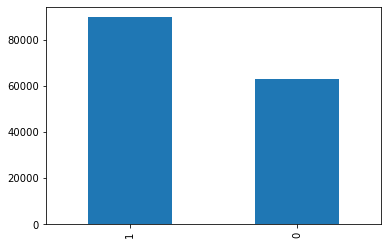

In [4]:
# class distribution
train_df['label'].value_counts().plot(kind='bar')
plt.show()

- **Not heavily imbalanced**

In [5]:
# train/val split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'], train_df['label'],
    test_size=VALIDATION_SIZE, random_state=RANDOM_SEED,
    stratify=train_df['label']
)

# look at obtained labels distribution
(
    y_train.value_counts(normalize=True),
    y_val.value_counts(normalize=True)
)

(1    0.587496
 0    0.412504
 Name: label, dtype: float64,
 1    0.587511
 0    0.412489
 Name: label, dtype: float64)

- We have **152k unique comments** in training data
- We can either train own `word2vec` model or download `pretrained embeddings`

In this example we will [download pretrained embeddings](http://nlp.stanford.edu/data/glove.6B.zip) (`glove 50, 6B`)

**Transform Words into Vectors**

In [6]:
# initialize vocab (fit on train)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='#$%&()*+-/:;<=>@[\\]^{|}~\t\n,.!"')
tokenizer.fit_on_texts(X_train)

print('Raw review: ', X_train.iloc[0])

Raw review:  If the picture overcrowds its screen, at least we must admit it is an impressive kaleidoscope; and probably nothing short of that could reflect the gaudy career of America's foremost showman.


`Tokenizer` from `keras.preprocessing.text` has the following logic:
- First it's fit on all text data, then it computes token frequencies and ranks them 
- Token that has index 1 has the most word frequency, then second, ...
- Parameter `num_words` defines number of words to keep 

In [7]:
# tokenizer has info about our vocab
word = 'super'

word_indx = tokenizer.word_index[word]
word_count = tokenizer.word_counts[word]

print(f'Word "{word}" appears {word_count} times')
print(f'Word "{word}" has index: {word_indx} ')

Word "super" appears 946 times
Word "super" has index: 1269 


In [8]:
# look at the most popular words
n = 5
top_n_word_counts = list(tokenizer.word_index.keys())[:n]
for word in top_n_word_counts:
    print(f'{word}: {tokenizer.word_counts[word]}')

the: 686911
a: 352446
and: 345069
of: 314398
to: 274789


- Most word counts have words that should be in stop words

In [9]:
# transform text into sequence of vocab indexes (index -> token)
X_train_enc = tokenizer.texts_to_sequences(X_train)
X_val_enc = tokenizer.texts_to_sequences(X_val)

print('Transformed review: \n', X_train_enc[0])

Transformed review: 
 [42, 1, 344, 57, 240, 29, 219, 77, 220, 1069, 8, 6, 28, 1007, 3, 243, 161, 338, 4, 11, 97, 4751, 1, 557, 4, 3797, 7133]


In [10]:
# look at sequence length distribution
seq_len_dist = pd.Series(X_train_enc).apply(len).sort_values(ascending=False)
seq_len_dist

81067     2109
20034     2084
69615     1922
52714     1876
134956    1732
          ... 
100477       0
53995        0
96621        0
45131        0
17490        0
Length: 137349, dtype: int64

- Some reviews have zero length -> probably words don't appear in vocab
- Probably it's better to exclude such observations -> they don't provide any value

In [11]:
# additionally: exclude zero seq len texts

- Each text has different length. Howeve, we must align it and make sure that **all texts have the same length**

In [12]:
# restrict each sequence by requred length
X_train_enc = pad_sequences(X_train_enc, maxlen=MAX_SEQUENCE_LENGTH)
X_val_enc = pad_sequences(X_val_enc, maxlen=MAX_SEQUENCE_LENGTH)

print('Transformed review (Length Restricted): \n', X_train_enc[0])

Transformed review (Length Restricted): 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   42
    1  344   57  240   29  219   77  220 1069    8    6   28 1007    3
  243  161  338    4   11   97 4751    1  557    4 3797 7133]


### Pretrained Embeddings Retrival
Let's download pretrained Glove Embeddings

In [13]:
def download_glove_embeddings(f_path):
    """Downloads pretrained embeddings."""
    embeddings = {}
    with open(f_path) as f:
        # get the total number of lines in the file for tqdm
        total_lines = sum(1 for line in f)
        f.seek(0)  # reset file pointer to the beginning
        
        for line in tqdm(f, total=total_lines, desc="Downloading Glove Embeddings"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
        del values, word, coefs, line
    return embeddings

In [14]:
glove_embeddings = download_glove_embeddings(
    f_path='/home/jovyan/work/data_sets/uds_sentiment_analysis/glove.6B/glove.6B.50d.txt'
)

- Unfortunately, not all words from downloaded pretrained embeddings are available for our task

In [15]:
# look at vocab overlap
first_10k = {k: v for k, v in tokenizer.word_index.items() if v < 10000}

first_10k_words_set = set(first_10k.keys())
glove_embeddings_words_set = set(glove_embeddings.keys())

missing_embeddings = first_10k_words_set.difference(glove_embeddings_words_set)
print(f'N Missing Embeddings {len(missing_embeddings)}')
print(f'N Missing Embeddings ', round(len(missing_embeddings)/10_000*100,2), '%')      

N Missing Embeddings 251
N Missing Embeddings  2.51 %


In [16]:
# prepare embedding matrix from Tokenizer: rows -> word indexes
embedding_matrix = np.zeros((tokenizer.num_words, EMBEDDING_DIM))

for word, i in first_10k.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('Obtained Embedding Matrix Shape: ', embedding_matrix.shape)

Obtained Embedding Matrix Shape:  (10000, 50)


### Recurrent Neural Networks
RNNs help to catch/understand a pattern that **depends on time or order.** For example, when we are trying to classify an episode from a film, it is important for us to know that there were a couple of episodes earlier, or in order to understand the meaning of a certain word, we need to know the context that came before it.

**Simple RNN**

In [18]:
NAME = "simple_rnn"
MONITOR_METRIC = 'val_acc'
EPOCHS = 20
BATCH_SIZE = 1024

# initialize embedding layer 
embedding_layer = Embedding(
    input_dim=tokenizer.num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False # we don't want to train new embeddings because we already downloaded pretrained!
)
                            
simple_rnn = Sequential()
simple_rnn.add(embedding_layer)
simple_rnn.add(SimpleRNN(100))
simple_rnn.add(Dense(1))
simple_rnn.add(Activation('sigmoid'))

# initialize callbacks
# automatic learning curves building
callback_1 = TensorBoard(
    log_dir='./logs/logs_{}'.format(NAME),
    histogram_freq=0,
    write_graph=False,
    write_images=False
)

# EarlyStopping callback
callback_2 = EarlyStopping(
    monitor=MONITOR_METRIC, min_delta=0, patience=5, verbose=0, mode='auto'
)


# best model callback
callback_3 = ModelCheckpoint(
    filepath="../models/model_{}.hdf5".format(NAME),
    monitor=MONITOR_METRIC,
    save_best_only=True,
    verbose=1
)

simple_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

simple_rnn.summary()

2024-04-16 18:21:41.892821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-16 18:21:41.892903: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-16 18:21:41.892923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c05a32572f15): /proc/driver/nvidia/version does not exist
2024-04-16 18:21:41.894162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            500000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               15100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 515,201
Trainable params: 15,201
Non-trainable params: 500,000
_________________________________________________________________


2024-04-16 18:21:42.105668: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 18:21:42.105729: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-04-16 18:21:42.106985: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


- Since we don't train first embedding layer we have 500k non trainable parameters

In [19]:
simple_rnn.fit(
    X_train_enc, y_train,
    validation_data=[X_val_enc, y_val], 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback_1, callback_2, callback_3]
)

2024-04-16 18:21:44.831920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
  2/135 [..............................] - ETA: 11s - loss: 0.7103 - accuracy: 0.5190 

2024-04-16 18:21:45.809453: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 18:21:45.809495: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-04-16 18:21:45.895189: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-04-16 18:21:45.903008: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-04-16 18:21:45.921005: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_21_45

2024-04-16 18:21:45.935596: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_21_45/c05a32572f15.trace.json.gz
2024-04-16 18:21:45.945871: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/prof

135/135 [==============================] - 11s 74ms/step - loss: 0.6167 - accuracy: 0.6504 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 12s 91ms/step - loss: 0.5823 - accuracy: 0.6888 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
135/135 [==============================] - 12s 90ms/step - loss: 0.5633 - accuracy: 0.7050 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
135/135 [==============================] - 10s 71ms/step - loss: 0.5562 - accuracy: 0.7097 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
135/135 [==============================] - 10s 76ms/step - loss: 0.5458 - accuracy: 0.7183 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
135/135 [==============================] - 10s 75ms/step - loss: 0.5333 - accuracy: 0.7260 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
135/135 [==============================] - 11s 80ms/step - loss: 0.5231 - accuracy: 0.73

In [20]:
%%time

# rnn inference
pred_proba_train_rnn = simple_rnn.predict(X_train_enc)
pred_proba_val_rnn = simple_rnn.predict(X_val_enc)

CPU times: user 32 s, sys: 12 s, total: 43.9 s
Wall time: 18 s


In [21]:
threshold = 0.5
pre_labels_val = np.where(pred_proba_val_rnn > threshold, 1, 0)

roc_auc_train_rnn = roc_auc_score(y_train, pred_proba_train_rnn)
roc_auc_val_rnn = roc_auc_score(y_val, pred_proba_val_rnn)
class_report_rnn = classification_report(y_val, pre_labels_val)

print('ROC-AUC (Train): ', roc_auc_train_rnn)
print('ROC-AUC (Validation): ', roc_auc_val_rnn)

print('\n', class_report_rnn)

ROC-AUC (Train):  0.8455963238135913
ROC-AUC (Validation):  0.8312706177799565

               precision    recall  f1-score   support

           0       0.76      0.57      0.65      6295
           1       0.74      0.87      0.80      8966

    accuracy                           0.75     15261
   macro avg       0.75      0.72      0.73     15261
weighted avg       0.75      0.75      0.74     15261



In [22]:
# custom testing
reviews_to_test = pd.Series([
    'The film was awesome. I liked the plot and actors!',
    'The film was bad. Such a boring and awful! Not Recommend!',
    'I love it!',
    'Not Recommend and do not waste your time',
])

reviews_vec = tokenizer.texts_to_sequences(reviews_to_test)
reviews_vec = pad_sequences(reviews_vec, maxlen=MAX_SEQUENCE_LENGTH)

simple_rnn.predict(reviews_vec)*100

array([[94.747   ],
       [ 3.217858],
       [63.054295],
       [14.95009 ]], dtype=float32)

### Long Short-Term Memory (LSTM)
LSTM has a number of advantages over a simple RNN. LSTM is **able to store the necessary information** about a certain object and not pay attention to irrelevant information. For example, a scene without mentioning the main character will not change information about him and, on the contrary, when mentioned, it will be focused.

**Forgetting Mechanism**

If the episode ends, for example, the model should forget the current location, time of day, and reset any information about the specific scene. However, if a character dies in an episode, the network must continue to remember that he is no longer alive.
In the end the model must know what is important and what is not when a new input appears.

**Remembering Mechanism**

When the model sees a new episode, it needs to decide whether to use and save any information about it. For example, we have seen a new meme, should we remeber it? Thus, when a new input comes, model first forgets long-term information. Then during learning it finds out what part of new data it must put in long-term memory. Later during training it decides what part of long-term memory important and must be used and what info is not important and might be forgotten.


### Advantage over RNN
RNN always rewrite memory whereas LSTM is more flexible and is able to store some info in long-term memory.

In [24]:
NAME = "simple_lstm"
MONITOR_METRIC = 'val_acc'
EPOCHS = 20
BATCH_SIZE = 1024

embedding_layer = Embedding(
    tokenizer.num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)
                            
simple_lstm = Sequential()
simple_lstm.add(embedding_layer)
simple_lstm.add(LSTM(100))
simple_lstm.add(Dense(1))
simple_lstm.add(Activation('sigmoid'))

simple_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

simple_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 560,501
Trainable params: 60,501
Non-trainable params: 500,000
_________________________________________________________________


In [25]:
simple_lstm.fit(
    X_train_enc, y_train,
    validation_data=[X_val_enc, y_val], 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/20
  1/135 [..............................] - ETA: 3:12 - loss: 0.8293 - accuracy: 0.4141

2024-04-16 18:25:30.087811: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 18:25:30.087868: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/135 [..............................] - ETA: 35s - loss: 0.7904 - accuracy: 0.4175 

2024-04-16 18:25:30.386412: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-04-16 18:25:30.400826: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-04-16 18:25:30.426955: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_25_30

2024-04-16 18:25:30.446879: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_25_30/c05a32572f15.trace.json.gz
2024-04-16 18:25:30.456726: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_25_30

2024-04-16 18:25:30.459396: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18

135/135 [==============================] - 34s 240ms/step - loss: 0.6040 - accuracy: 0.6636 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 32s 237ms/step - loss: 0.5470 - accuracy: 0.7158 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
135/135 [==============================] - 32s 237ms/step - loss: 0.5235 - accuracy: 0.7330 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
135/135 [==============================] - 32s 235ms/step - loss: 0.5103 - accuracy: 0.7424 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
135/135 [==============================] - 32s 234ms/step - loss: 0.4979 - accuracy: 0.7520 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
135/135 [==============================] - 32s 235ms/step - loss: 0.4886 - accuracy: 0.7580 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
135/135 [==============================] - 33s 241ms/step - loss: 0.4780 - accurac

In [26]:
%%time

# lstm inference
pred_proba_train_lstm = simple_lstm.predict(X_train_enc)
pred_proba_val_lstm = simple_lstm.predict(X_val_enc)

CPU times: user 1min 30s, sys: 46 s, total: 2min 16s
Wall time: 56.4 s


In [27]:
threshold = 0.5
pre_labels_val = np.where(pred_proba_val_lstm > threshold, 1, 0)

roc_auc_train_lstm = roc_auc_score(y_train, pred_proba_train_lstm)
roc_auc_val_lstm = roc_auc_score(y_val, pred_proba_val_lstm)
class_report_lstm = classification_report(y_val, pre_labels_val)

print('ROC-AUC (Train): ', roc_auc_train_lstm)
print('ROC-AUC (Validation): ', roc_auc_val_lstm)

print('\n', class_report_lstm)

ROC-AUC (Train):  0.8976642858370705
ROC-AUC (Validation):  0.8610103529404262

               precision    recall  f1-score   support

           0       0.76      0.69      0.72      6295
           1       0.80      0.84      0.82      8966

    accuracy                           0.78     15261
   macro avg       0.78      0.77      0.77     15261
weighted avg       0.78      0.78      0.78     15261



In [28]:
# custom testing (test the same observations to compare predicted probability)
reviews_to_test = pd.Series([
    'The film was awesome. I liked the plot and actors!',
    'The film was bad. Such a boring and awful! Not Recommend!',
    'I love it!',
    'Not Recommend and do not waste your time',
])

reviews_vec = tokenizer.texts_to_sequences(reviews_to_test)
reviews_vec = pad_sequences(reviews_vec, maxlen=MAX_SEQUENCE_LENGTH)

simple_lstm.predict(reviews_vec)*100

array([[67.68521  ],
       [ 4.2813063],
       [73.819824 ],
       [33.777557 ]], dtype=float32)

### Modified LSTM
Let's try to improve the performance of baseline LSTM model. In practice, the following parameters work in the best way:
- Dropout (less overfitting on certain words)
- Masking in Embeddings (in this case the loss doesn't take into account 0 when review is padded)
- L1/L2 regularization (works not so well in practice, LSTM alredy prevents gradient exploding)


In [31]:
NAME = "modified_lstm"
MONITOR_METRIC = 'val_acc'
EPOCHS = 20
BATCH_SIZE = 1024

embedding_layer = Embedding(
    tokenizer.num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,
    mask_zero=True
)
                            
modified_lstm = Sequential()
modified_lstm.add(embedding_layer)
modified_lstm.add(Dropout(0.2))
modified_lstm.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
modified_lstm.add(Dropout(0.2))
modified_lstm.add(Dense(1))
modified_lstm.add(Activation('sigmoid'))

modified_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

modified_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
dropout (Dropout)            (None, 40, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 560,501
Trainable params: 60,501
Non-trainable params: 500,000
___________________________________________

In [32]:
modified_lstm.fit(
    X_train_enc, y_train,
    validation_data=[X_val_enc, y_val], 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/20
  1/135 [..............................] - ETA: 5:38 - loss: 0.6911 - accuracy: 0.5293

2024-04-16 18:37:54.477082: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 18:37:54.477126: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/135 [..............................] - ETA: 50s - loss: 0.6919 - accuracy: 0.5361 

2024-04-16 18:37:54.922518: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-04-16 18:37:54.955394: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-04-16 18:37:55.021079: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_37_54

2024-04-16 18:37:55.085711: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_37_54/c05a32572f15.trace.json.gz
2024-04-16 18:37:55.112293: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_37_54

2024-04-16 18:37:55.114551: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18

135/135 [==============================] - 56s 401ms/step - loss: 0.6047 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 51s 378ms/step - loss: 0.5711 - accuracy: 0.6963 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
135/135 [==============================] - 49s 361ms/step - loss: 0.5529 - accuracy: 0.7107 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
135/135 [==============================] - 49s 366ms/step - loss: 0.5420 - accuracy: 0.7186 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
135/135 [==============================] - 48s 354ms/step - loss: 0.5319 - accuracy: 0.7246 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
135/135 [==============================] - 48s 356ms/step - loss: 0.5272 - accuracy: 0.7302 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
135/135 [==============================] - 49s 365ms/step - loss: 0.5205 - accurac

In [33]:
%%time

# lstm inference
pred_proba_train_lstm = modified_lstm.predict(X_train_enc)
pred_proba_val_lstm = modified_lstm.predict(X_val_enc)

CPU times: user 2min 12s, sys: 42.7 s, total: 2min 55s
Wall time: 45.7 s


In [34]:
threshold = 0.5
pre_labels_val = np.where(pred_proba_val_lstm > threshold, 1, 0)

roc_auc_train_lstm = roc_auc_score(y_train, pred_proba_train_lstm)
roc_auc_val_lstm = roc_auc_score(y_val, pred_proba_val_lstm)
class_report_lstm = classification_report(y_val, pre_labels_val)

print('ROC-AUC (Train): ', roc_auc_train_lstm)
print('ROC-AUC (Validation): ', roc_auc_val_lstm)

print('\n', class_report_lstm)

ROC-AUC (Train):  0.8694888480839094
ROC-AUC (Validation):  0.8547924672449817

               precision    recall  f1-score   support

           0       0.76      0.64      0.70      6295
           1       0.77      0.86      0.81      8966

    accuracy                           0.77     15261
   macro avg       0.77      0.75      0.76     15261
weighted avg       0.77      0.77      0.77     15261



In [35]:
# custom testing (test the same observations to compare predicted probability)
reviews_to_test = pd.Series([
    'The film was awesome. I liked the plot and actors!',
    'The film was bad. Such a boring and awful! Not Recommend!',
    'I love it!',
    'Not Recommend and do not waste your time',
])

reviews_vec = tokenizer.texts_to_sequences(reviews_to_test)
reviews_vec = pad_sequences(reviews_vec, maxlen=MAX_SEQUENCE_LENGTH)

simple_lstm.predict(reviews_vec)*100

array([[67.68521  ],
       [ 4.2813063],
       [73.819824 ],
       [33.777557 ]], dtype=float32)

### Convolutional Neural Net
We can add convolutional layers into RNNs. The main issue: overfitting on little data.

In [38]:
NAME = "lstm_cnn"
MONITOR_METRIC = 'val_acc'
EPOCHS = 20
BATCH_SIZE = 1024

# initialize model
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(tokenizer.num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True))
lstm_cnn.add(Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid"))
lstm_cnn.add(Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid"))
lstm_cnn.add(Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid"))
lstm_cnn.add(GlobalMaxPooling1D())
lstm_cnn.add(Dense(100, activation='relu'))
lstm_cnn.add(Dropout(0.5))
lstm_cnn.add(Dense(100, activation='relu'))
lstm_cnn.add(Dense(1, activation='sigmoid'))

lstm_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 37, 100)           20100     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 100)           40100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 100)           40100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [39]:
lstm_cnn.fit(
    X_train_enc, y_train,
    validation_data=[X_val_enc, y_val], 
    batch_size=BATCH_SIZE,
    epochs=5, # set 5 epochs because prone to overfitting
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/5
  2/135 [..............................] - ETA: 18s - loss: 0.6901 - accuracy: 0.5737 

2024-04-16 18:58:35.198387: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 18:58:35.198430: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-04-16 18:58:35.369114: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-04-16 18:58:35.370408: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-04-16 18:58:35.377714: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35

2024-04-16 18:58:35.381176: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35/c05a32572f15.trace.json.gz
2024-04-16 18:58:35.385394: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/prof

  3/135 [..............................] - ETA: 23s - loss: 0.6877 - accuracy: 0.5843

2024-04-16 18:58:35.406222: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35
Dumped tool data for xplane.pb to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35/c05a32572f15.xplane.pb
Dumped tool data for overview_page.pb to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35/c05a32572f15.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35/c05a32572f15.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35/c05a32572f15.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_18_58_35/c05a32572f15.kernel_stats.pb



135/135 [==============================] - 20s 141ms/step - loss: 0.5766 - accuracy: 0.6815 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
135/135 [==============================] - 19s 139ms/step - loss: 0.4157 - accuracy: 0.8087 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
135/135 [==============================] - 21s 158ms/step - loss: 0.3663 - accuracy: 0.8373 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
135/135 [==============================] - 21s 156ms/step - loss: 0.3222 - accuracy: 0.8603 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
135/135 [==============================] - 23s 167ms/step - loss: 0.2700 - accuracy: 0.8893 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [40]:
%%time

# lstm inference
pred_proba_train_lstm = lstm_cnn.predict(X_train_enc)
pred_proba_val_lstm = lstm_cnn.predict(X_val_enc)

CPU times: user 42.3 s, sys: 8.75 s, total: 51 s
Wall time: 14.7 s


In [41]:
threshold = 0.5
pre_labels_val = np.where(pred_proba_val_lstm > threshold, 1, 0)

roc_auc_train_lstm = roc_auc_score(y_train, pred_proba_train_lstm)
roc_auc_val_lstm = roc_auc_score(y_val, pred_proba_val_lstm)
class_report_lstm = classification_report(y_val, pre_labels_val)

print('ROC-AUC (Train): ', roc_auc_train_lstm)
print('ROC-AUC (Validation): ', roc_auc_val_lstm)

print('\n', class_report_lstm)

ROC-AUC (Train):  0.9792408073529836
ROC-AUC (Validation):  0.8746965280717182

               precision    recall  f1-score   support

           0       0.76      0.73      0.75      6295
           1       0.82      0.84      0.83      8966

    accuracy                           0.79     15261
   macro avg       0.79      0.79      0.79     15261
weighted avg       0.79      0.79      0.79     15261



### RNN on Symbols 

**What Preprocessing is Required for Symbols?**
- similar to words, we have to train embeddings for symbols
- represent symbols as OHE embeddings

**What Symbols to Include?**
- common practice (english) -> 70 symbols: lower case letters, numbers(1, 2, ..., 9) and punctuation
- depending on a task, symbols length might be different

In [107]:
ascii_lowercase = string.ascii_lowercase
digits = string.digits
punctuation = string.punctuation

print('lowercase letters: ', ascii_lowercase)
print('digits: ', digits)
print('punctuation: ', punctuation)

# create char vocab
def get_char_vocab():
    alphabet = (
        list(string.ascii_lowercase) + 
        list(string.digits) + 
        list(string.punctuation) +
        [' ', '\n']
    )
    char_vocab = {
        char: i + 1 for i, char  in enumerate(alphabet)
    }
    vocab_size = len(char_vocab.keys())
    return char_vocab, vocab_size

def text2char_seq(text: list, char_vocab: dict):
    seq = []
    for char in text:
        char = char_vocab.get(char, None)
        if char:
            seq.append(char)
    return seq

lowercase letters:  abcdefghijklmnopqrstuvwxyz
digits:  0123456789
punctuation:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [108]:
# test transformation
vocab, vocab_size  = get_char_vocab()
sentence_char_seq_enc = text2char_seq(X_train[0].lower(), char_vocab=vocab)

print('Original Text: ', X_train[0].lower())
print('\nCharacter Sequence Encoded: \n', sentence_char_seq_enc)

Original Text:  to an entire generation of filmgoers, it just might represent the most significant leap in storytelling that they will ever see...

Character Sequence Encoded: 
 [20, 15, 69, 1, 14, 69, 5, 14, 20, 9, 18, 5, 69, 7, 5, 14, 5, 18, 1, 20, 9, 15, 14, 69, 15, 6, 69, 6, 9, 12, 13, 7, 15, 5, 18, 19, 48, 69, 9, 20, 69, 10, 21, 19, 20, 69, 13, 9, 7, 8, 20, 69, 18, 5, 16, 18, 5, 19, 5, 14, 20, 69, 20, 8, 5, 69, 13, 15, 19, 20, 69, 19, 9, 7, 14, 9, 6, 9, 3, 1, 14, 20, 69, 12, 5, 1, 16, 69, 9, 14, 69, 19, 20, 15, 18, 25, 20, 5, 12, 12, 9, 14, 7, 69, 20, 8, 1, 20, 69, 20, 8, 5, 25, 69, 23, 9, 12, 12, 69, 5, 22, 5, 18, 69, 19, 5, 5, 50, 50, 50]


In [104]:
%%time

# apply character transformation
X_train_char_enc = X_train.str.lower().apply(lambda x: text2char_seq(x, vocab))
X_val_char_enc = X_val.str.lower().apply(lambda x: text2char_seq(x, vocab))

# align vectors using padding
X_train_char_enc = pad_sequences(X_train_char_enc, maxlen=MAX_SEQUENCE_LENGTH, value=0)
X_val_char_enc = pad_sequences(X_val_char_enc, maxlen=MAX_SEQUENCE_LENGTH, value=0)

CPU times: user 20.3 s, sys: 316 ms, total: 20.6 s
Wall time: 20.6 s


**Char Embedding CNN**

In [114]:
NAME = "char_cnn"
MONITOR_METRIC = 'val_acc'
EPOCHS = 20
BATCH_SIZE = 1024

char_cnn = Sequential()
char_cnn.add(Embedding(vocab_size+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True))
char_cnn.add(Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid"))
char_cnn.add(Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid"))
char_cnn.add(Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid"))
char_cnn.add(GlobalMaxPooling1D())
char_cnn.add(Dense(100, activation='relu'))
char_cnn.add(Dropout(0.5))
char_cnn.add(Dense(100, activation='relu'))
char_cnn.add(Dense(1, activation='sigmoid'))

char_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

char_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 50)            3550      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 37, 100)           20100     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 34, 100)           40100     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 31, 100)           40100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

In [115]:
char_cnn.fit(
    X_train_char_enc, y_train,
    validation_data=[X_val_char_enc, y_val], 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/20
  2/135 [..............................] - ETA: 17s - loss: 0.6928 - accuracy: 0.5151 

2024-04-16 20:28:03.541576: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 20:28:03.541634: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-04-16 20:28:03.694377: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-04-16 20:28:03.695258: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-04-16 20:28:03.701160: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_20_28_03

2024-04-16 20:28:03.704520: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_20_28_03/c05a32572f15.trace.json.gz
2024-04-16 20:28:03.709339: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/prof

135/135 [==============================] - 20s 141ms/step - loss: 0.6705 - accuracy: 0.5876 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 19s 140ms/step - loss: 0.6435 - accuracy: 0.6194 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
135/135 [==============================] - 20s 146ms/step - loss: 0.6146 - accuracy: 0.6546 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
135/135 [==============================] - 20s 148ms/step - loss: 0.5846 - accuracy: 0.6836 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
135/135 [==============================] - 20s 150ms/step - loss: 0.5610 - accuracy: 0.7042 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
135/135 [==============================] - 21s 154ms/step - loss: 0.5426 - accuracy: 0.7198 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
135/135 [==============================] - 19s 143ms/step - loss: 0.5273 - accurac

In [118]:
%%time

# lstm inference
pred_proba_train_char_cnn = char_cnn.predict(X_train_char_enc)
pred_proba_val_char_cnn = char_cnn.predict(X_val_char_enc)

CPU times: user 35.3 s, sys: 7.6 s, total: 42.9 s
Wall time: 12.3 s


In [119]:
threshold = 0.5
pre_labels_val = np.where(pred_proba_val_char_cnn > threshold, 1, 0)

roc_auc_train_char_cnn = roc_auc_score(y_train, pred_proba_train_char_cnn)
roc_auc_val_char_cnn = roc_auc_score(y_val, pred_proba_val_char_cnn)
class_report_char_cnn = classification_report(y_val, pre_labels_val)

print('ROC-AUC (Train): ', roc_auc_train_char_cnn)
print('ROC-AUC (Validation): ', roc_auc_val_char_cnn)

print('\n', class_report_lstm)

ROC-AUC (Train):  0.9321483904024039
ROC-AUC (Validation):  0.7690857545502849

               precision    recall  f1-score   support

           0       0.76      0.73      0.75      6295
           1       0.82      0.84      0.83      8966

    accuracy                           0.79     15261
   macro avg       0.79      0.79      0.79     15261
weighted avg       0.79      0.79      0.79     15261



**Results Analysis**
- The main issue -> we don't consider word orders because there is no RNN inside

### OHE Encoding

In [126]:
# OHE function
def apply_ohe(x, sz):
    return tf.cast(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1), tf.float32)

In [122]:
# test OHE transformation
# apply_ohe()

In [131]:
NAME = "char_cnn_ohe"
EPOCHS = 20
BATCH_SIZE = 1024

# input initialization
in_sentence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

# Lambda layer for OHE transformation
embedded = Lambda(
    apply_ohe,
    output_shape=lambda x: (x[0], x[1], vocab_size),
    arguments={"sz": vocab_size}
)(in_sentence)

block = embedded

# convolutions with MaxPooling
for i in range(3):
    block = Conv1D(activation="relu", filters=100, kernel_size=4, padding="valid")(block)
    if i == 0:
        block = MaxPooling1D(pool_size=5)(block)
        
# LSTM cell
block = LSTM(128, dropout=0.1, recurrent_dropout=0.1)(block)
block = Dense(100, activation='relu')(block)
block = Dense(1, activation='sigmoid')(block)

# build model
char_cnn_ohe = Model(inputs=in_sentence, outputs=block)
char_cnn_ohe.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [132]:
char_cnn_ohe.fit(
    X_train_char_enc, y_train,
    validation_data=[X_val_char_enc, y_val], 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/20
  2/135 [..............................] - ETA: 10s - loss: 0.6916 - accuracy: 0.5151 

2024-04-16 20:48:05.041191: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-04-16 20:48:05.041269: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-04-16 20:48:05.172974: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-04-16 20:48:05.176036: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-04-16 20:48:05.184692: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_20_48_05

2024-04-16 20:48:05.189958: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/logs_simple_rnn/train/plugins/profile/2024_04_16_20_48_05/c05a32572f15.trace.json.gz
2024-04-16 20:48:05.199368: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/logs_simple_rnn/train/plugins/prof

134/135 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.5935

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>]


**CNN Advantages over LSTM**
- No need to store thousands of words, only some number of symbols 
- Typos don't affect on model performance (e.g. `"the bst film"` -> will be well classified by CNN, LSTM will ignore)
- Can be applied for any language
- Doesn't require to have a big vocabularly

In [ ]:
%%time

# lstm inference
pred_proba_train_char_cnn = char_cnn_ohe.predict(X_train_char_enc)
pred_proba_val_char_cnn = char_cnn_ohe.predict(X_val_char_enc)

In [133]:
threshold = 0.5
pre_labels_val = np.where(pred_proba_val_char_cnn > threshold, 1, 0)

roc_auc_train_char_cnn = roc_auc_score(y_train, pred_proba_train_char_cnn)
roc_auc_val_char_cnn = roc_auc_score(y_val, pred_proba_val_char_cnn)
class_report_char_cnn = classification_report(y_val, pre_labels_val)

print('ROC-AUC (Train): ', roc_auc_train_char_cnn)
print('ROC-AUC (Validation): ', roc_auc_val_char_cnn)

print('\n', class_report_lstm)

ROC-AUC (Train):  0.6703052980671775
ROC-AUC (Validation):  0.6636913929721618

               precision    recall  f1-score   support

           0       0.76      0.73      0.75      6295
           1       0.82      0.84      0.83      8966

    accuracy                           0.79     15261
   macro avg       0.79      0.79      0.79     15261
weighted avg       0.79      0.79      0.79     15261



### Best Practice

**How else Performance Might be Improved**
- Increase embeddings dimension
- Increase LSTM output dimension
- Add more layers and Bidirectional LSTM (when have enough data and overfitting doesn't happen)
- Switching from little to bigger batch
- Trying different dropout values and optimizaers
- Increase vocab size (more symbols, words, ...)
- Play around with `MAX_SEQUENCE_LENGTH`
- Different Architectures

**Advice from Practice**
- little data and text len is short -> linear methods (e.g. LogReg or SVM with n-gramms with hard regularization)
- little data and text lengthy -> LSTM with not many layers
- much data -> different LSTM and CNN architectures

### Reference
- [GitNotebook](https://github.com/Yorko/mlcourse.ai/blob/main/jupyter_russian/tutorials/dl_sentiment_analysis_radchenko.ipynb)
- [Nice Repo](https://github.com/udsclub/workshop/tree/master)

In [4]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [6]:
!jt -t gruvboxl